Title: Thinkful Unit 2 Lesson 2, Naive Bayes
<br>Author: Naomi Hernandez
<br>Date: 2019-04-19

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import os
from glob import glob as glb
import re

In [126]:
path = "H:/Documents/Training/Thinkful/sentiment_labelled_sentences/sls"

In [127]:
def grep_like(patt, x):
    try:
        lst = re.findall(patt, x)
        if len(lst)>0:
            result = lst[0]
        else:
            result=None
        return(result)
    
    except Exception as e:
        print(e)
        return(None)
    
    # re.findall('.*amazon.*', files[0])

In [128]:
files = glb('{}/*.txt'.format(path))

am = list(filter(lambda x: x!= None, map(lambda x: grep_like('.*amazon.*', x), files)))[0]

In [129]:
raw = pd.read_csv(am, sep='\t', header=None, names=['text_raw', 'target'])
raw.head()

,text_raw,target
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


#### Word and case-based features

In [130]:
# Positive and negative key words
neg = [r'no\s*way', 'fooled', 'mislea?d', 'problem', 'unacceptable', 'hate', 'unusable', 'poor', 'disappoint', 'n[o\']t *recommend', 'broke', 'flimsy']
pos = ['good', 'excellent', '(?<!(not ))great', '(?<!(not ))impressed', '(?<!(not ))recommend', 'love', 'best', 'ideal', 'high', 'well', 'fine', 'happy', 'delight']

In [131]:
# Creating dataframe for labels and keywords to generate nicely labeled columns
md = pd.DataFrame(columns=['positive', 'keyword', 'bkey'])
md.loc[:, 'keyword'] = neg
md.loc[:, 'positive'] = 0

md = pd.concat([md, pd.DataFrame(pos, columns=['keyword'])], sort=False)\
    .reset_index().drop('index', axis=1)
md.loc[md.positive != 0, 'positive'] = 1
md.loc[md.keyword.str.contains(r'[\\s\(\[]'), 'bkey'] = md.keyword.apply(lambda x: r'{0}\b'.format(x))
md.loc[md.bkey.isna(), 'bkey'] = md.keyword.apply(lambda x: r'\b{0}\b'.format(x))
md.loc[:, 'label'] = md.keyword
md.loc[md.keyword.str.contains(r'\\s|\[|\(|\?'), 'label'] = ['no_way',
                                                             'mislead',
                                                             'not_recommend',
                                                             'not_great',
                                                             'not_impressed',
                                                             'not_recommend']

In [132]:
# Generate columns

for r in md.index:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    raw[md.loc[r, 'label']] = raw.text_raw.str.contains(md.loc[r, 'bkey'], case=False)
    
# raw

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [134]:
# Coding upper case
raw['upper'] = raw.text_raw.str.isupper()

#### Calculate number of messages that contain any features
Initially, only 20% (n=198) of the 1000 records are flagged with the current features. Once I remembered to ignore case, this increased to a third (n=337).

In [136]:
sm = raw[pd.Series(raw.columns).iloc[2:]].apply(lambda x: sum(x), axis=1)
print(len(sm.loc[sm==1]))

337


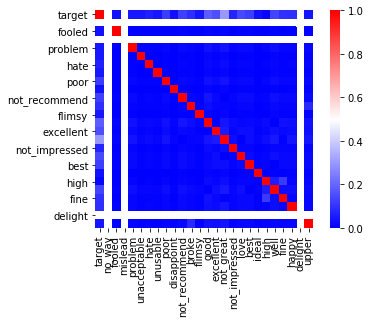

                 target  no_way    fooled  mislead   problem  unacceptable  \
target         1.000000     NaN -0.031686      NaN -0.044278     -0.044833   
no_way              NaN     NaN       NaN      NaN       NaN           NaN   
fooled        -0.031686     NaN  1.000000      NaN -0.003635     -0.001418   
mislead             NaN     NaN       NaN      NaN       NaN           NaN   
problem       -0.044278     NaN -0.003635      NaN  1.000000     -0.005143   
unacceptable  -0.044833     NaN -0.001418      NaN -0.005143      1.000000   
hate          -0.063468     NaN -0.002007      NaN -0.007280     -0.002840   
unusable      -0.044833     NaN -0.001418      NaN -0.005143     -0.002006   
poor          -0.119339     NaN -0.003774      NaN -0.013689     -0.005340   
disappoint    -0.031686     NaN -0.001002      NaN -0.003635     -0.001418   
not_recommend  0.122626     NaN -0.004750      NaN -0.017230     -0.006721   
broke         -0.089938     NaN -0.002844      NaN -0.010317    

In [145]:
fcorr = raw.iloc[1:].corr()
sns.heatmap(fcorr.abs(), cmap='bwr', square=True)
plt.show()

print(fcorr)

Three features--no_way, mislead, and delight--appear to be too sparsely populated to detrmine any correlations at all. I therefore excluded them.

In [155]:
drp = ['no_way', 'mislead', 'delight', 'text_raw', 'target']
feat = raw.drop(drp, axis=1).copy()
target = raw.target
# feat.head()

### Modeling
My final accuracy is 75%, with 255 items mislabeled. That's...not great.

In [158]:
from sklearn.naive_bayes import BernoulliNB

# Instantiate model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(feat, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(feat)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    feat.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 255


## Part 2: Using with a new dataset

In [176]:
nd = pd.read_csv(files[3], header=None, names=['text_raw', 'target'], sep='\t')
nd.head()

,text_raw,target
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Feature creation

In [177]:
for r in md.index:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    nd[md.loc[r, 'label']] = nd.text_raw.str.contains(md.loc[r, 'bkey'], case=False)

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [178]:
nd['upper'] = nd.text_raw.str.isupper()

In [181]:
data = nd.drop(drp, axis=1)
target = nd.target

In [182]:
# Instantiate model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(feat)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 481


Using the Amazon model on the Yelp dataset gave us an accuracy of 52%. In other words, we could have tossed a coin and ended up with approximately the same results. It looks like NLP is specific to the problem at hand.